
# Use Tensorflow to recognize hand-written digits with `ibm-watson-machine-learning`

This notebook facilitates Tensorflow and Watson Machine Learning service. It contains steps and code to work with [ibm-watson-machine-learning](https://pypi.python.org/pypi/ibm-watson-machine-learning) library available in PyPI repository. It also introduces commands for getting model and training data, persisting model, deploying model and scoring it.

Some familiarity with Python is helpful. This notebook uses Python 3.

## Learning goals

The learning goals of this notebook are:

-  Download an externally trained Tensorflow model with dataset.
-  Persist an external model in Watson Machine Learning repository.
-  Deploy model for online scoring using client library.
-  Score sample records using client library.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Download externally created Tensorflow model and data](#download)
3.	[Persist externally created Tensforflow model](#persistence)
4.	[Deploy and score in a Cloud](#scoring)
5.  [Clean up](#cleanup)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener no referrer">here</a>).

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your WML instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [1]:

api_key = 'API_KEY' #See above
location = 'us-south'

In [2]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [31]:
!pip install -U ibm-watson-machine-learning

Requirement already up-to-date: ibm-watson-machine-learning in /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages (1.0.45)


In [9]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9681 sha256=d8e87b3d175b67c3ed2c4707813f21d005fd23728b22e08a0f571070d6b7482c
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click New Deployment Space
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press Create
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [1]:
client.spaces.list()

NameError: name 'client' is not defined

In [5]:
space_id = 'space_id' #See above

You can use `list` method to print all existing spaces.

In [2]:
client.spaces.list(limit=10)

NameError: name 'client' is not defined

To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [6]:
client.set.default_space(space_id)

'SUCCESS'

<a id="download"></a>
## 2. Download externally created Tensorflow model and data
In this section, you will download externally created Tensorflow models and data used for training it.

In [10]:
import os
import wget

data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    
model_path = os.path.join(data_dir, 'mnist-tf-hpo-saved-model.tar.gz')
if not os.path.isfile(model_path):
    wget.download("https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/models/tensorflow/mnist/mnist-tf-hpo-saved-model.tar.gz", out=data_dir)  

In [11]:
import os
import wget

data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    
filename = os.path.join(data_dir, 'mnist.npz')
if not os.path.isfile(filename):
    wget.download('https://s3.amazonaws.com/img-datasets/mnist.npz', out=data_dir)  

In [12]:
import numpy as np

dataset = np.load(filename)
x_test = dataset['x_test']

In [13]:
x_test.shape

(10000, 28, 28)

<a id="persistence"></a>
## 3. Persist externally created Tensorflow model

In this section, you will learn how to store your model in Watson Machine Learning repository by using the IBM Watson Machine Learning SDK.

### 3.1: Publish model

#### Publish model in Watson Machine Learning repository on Cloud.

Define model name, autor name and email.

In [14]:
sofware_spec_uid = client.software_specifications.get_id_by_name("default_py3.7")

In [15]:
metadata = {
            client.repository.ModelMetaNames.NAME: 'External Tensorflow model',
            client.repository.ModelMetaNames.TYPE: 'tensorflow_2.1',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

published_model = client.repository.store_model(
    model=model_path,
    meta_props=metadata)

### 3.2: Get model details

In [3]:
import json

published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

NameError: name 'client' is not defined

### 3.3 Get all models

In [4]:
models_details = client.repository.list_models()

NameError: name 'client' is not defined

In [18]:
client.model_definitions.delete('37a35b6f-53a9-4418-9a8c-690b50d10ddf')

'SUCCESS'

In [5]:
models_details = client.repository.list_models()

NameError: name 'client' is not defined

<a id="scoring"></a>
## 4. Deploy and score in a Cloud

In this section you will learn how to create online scoring and to score a new data record by using the IBM Watson Machine Learning SDK.

### 4.1: Create model deployment

#### Create online deployment for published model

In [20]:
deployments_details = client.deployments.get_details()
print(deployments_details)

{'resources': []}


In [21]:
for deployment in deployments_details['resources']:
    client.deployments.delete(deployment['metadata']['id'])

In [21]:
client.deployments.list(limit=10)

----  ----  -----  -------
GUID  NAME  STATE  CREATED
----  ----  -----  -------


In [22]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of external Tensorflow model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(published_model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '29c650c0-9ed1-46c6-ad11-5d86cf8f1af4' started

#######################################################################################


initializing...
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='663d1c35-389b-4c1d-8f24-203406138a38'
------------------------------------------------------------------------------------------------




**Note**: Here we use deployment url saved in published_model object. In next section, we show how to retrive deployment url from Watson Machine Learning instance.

In [6]:
client.deployments.list(limit=10)

NameError: name 'client' is not defined

In [24]:
deployment_uid = client.deployments.get_uid(created_deployment)

In [25]:
print(deployment_uid)

663d1c35-389b-4c1d-8f24-203406138a38


Now you can print an online scoring endpoint. 

In [26]:
scoring_endpoint = client.deployments.get_scoring_href(created_deployment)
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/ml/v4/deployments/663d1c35-389b-4c1d-8f24-203406138a38/predictions


You can also list existing deployments.

In [7]:
client.deployments.list()

NameError: name 'client' is not defined

### 4.2: Get deployment details

In [8]:
deployment_details = client.deployments.get_details(deployment_uid)
print(json.dumps(deployment_details, indent=2))

NameError: name 'client' is not defined

### 4.3: Score

You can use below method to do test scoring request against deployed model.

Let's first visualize two samples from dataset, we'll use for scoring.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

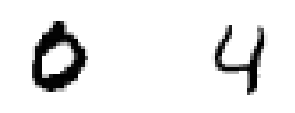

In [38]:
for i, image in enumerate([x_test[3], x_test[4]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

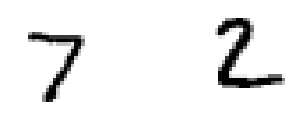

In [54]:
'''
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
'''


Prepare scoring payload with records to score.

In [39]:
score_0 = x_test[3].flatten().tolist()
score_1 = x_test[4].flatten().tolist()

In [55]:
#score_0 = x_test[0].flatten().tolist()
#score_1 = x_test[1].flatten().tolist()

In [40]:
scoring_payload = {"input_data": [{"values": [score_0, score_1]}]}

Use ``client.deployments.score()`` method to run scoring.

In [41]:
predictions = client.deployments.score(deployment_uid, scoring_payload)

Let's print the result of predictions.

In [42]:
import json
print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "id": "classes",
      "values": [
        0,
        4
      ]
    }
  ]
}


As you can see, predicted values are the same one as displayed above from test dataset.

<a id="cleanup"></a>
## 5. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 6. Summary and next steps

 You successfully completed this notebook! You learned how to use Pytorch machine learning library as well as Watson Machine Learning for model creation and deployment. Check out our _[Online Documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html?context=analytics?pos=2)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Daniel Ryszka**, Software Engineer

In [ ]:
import requests

# NOTE: you must manually set API_KEY below using information retrieved from your IBM Cloud account.
API_KEY = "<your API key>"
token_response = requests.post('https://iam.ng.bluemix.net/identity/token', data={"apikey": API_KEY, "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'})
mltoken = token_response.json()["access_token"]

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = {"input_data": [{"fields": [array_of_input_fields], "values": [array_of_values_to_be_scored, another_array_of_values_to_be_scored]}]}

response_scoring = requests.post('https://us-south.ml.cloud.ibm.com/ml/v4/deployments/e792c412-9819-42cb-b8a9-6c78dafd6002/predictions?version=2021-01-17', json=payload_scoring, headers={'Authorization': 'Bearer ' + mltoken})
print("Scoring response")
print(response_scoring.json())

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.